import the libraries

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

import the data set

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


delete the unnecessary column(s)

In [3]:
churn_data = churn_data.drop('RowNumber', axis=1)

what is the age range?

In [4]:
print(churn_data['Age'].min(), churn_data['Age'].max(), sep=', ')

18, 92


create a category for each generation

In [5]:
age_conditions = [churn_data['Age'] < 11, # no customer with this age, but a category is still needed
                  churn_data['Age'].between(11, 26), # gen z
                  churn_data['Age'].between(27, 42), # millenials
                  churn_data['Age'].between(43, 58), # gen x
                  churn_data['Age'].between(59, 68), # boomers ii
                  churn_data['Age'].between(69, 77), # boomers i
                  churn_data['Age'].between(78, 95) # post-war
                  ]
age_category = ['<11', '11-26', '27-42', '43-58', '59-68', '69-77', '78-95', '95+'] # category name
churn_data['AgeRange'] = np.select(age_conditions, age_category[:-1], age_category[-1])

create a function to change Exited into a proper category

In [6]:
#Exited: 1 - left, 0 - active

#create a function to change Exited into a category
def status_loyalty(x):
    if x == 1:
        return 'Exited'
    elif x == 0:
        return 'Loyal'
    
#apply the function and create a new column
churn_data['Status'] = churn_data['Exited'].apply(status_loyalty)

create a function to change IsActiveMember into a proper category

In [7]:
#IsActiveMember: 1 - Active, 0 - Inactive

#create a function to change IsActiveMember into a category
def status_active(x):
    if x == 1:
        return 'Active'
    elif x == 0:
        return 'Inactive'
    
#apply the function and create a new column
churn_data['AccountStatus'] = churn_data['IsActiveMember'].apply(status_active)

Exercise 9.1: \
Каково соотношение ушедших и лояльных клиентов? \
Покажите это на графике и дайте комментарий по соотношению.

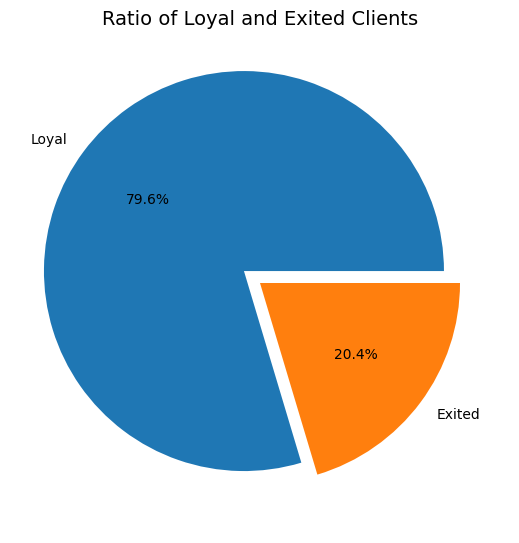

In [8]:
#create a variable for client status, and find its proportion
loyalty_status = churn_data['Status'].value_counts()

#build a pie chart to show the ratio difference between loyal and exited clients
fig = plt.figure(figsize=(5, 5)) #set the canvas
pie_data = fig.add_axes([0, 0, 1, 1]) #full scale
pie_data.pie(
    loyalty_status,
    labels=('Loyal', 'Exited'),
    autopct='%.1f%%', # to 1dp
    explode = [0.1, 0] #split exited from loyal
);

title = pie_data.set_title('Ratio of Loyal and Exited Clients', fontsize=14)

Comments: \
Loyalty status is a category, thus can be visualised by using a pie chart. \
The chart shows that there are more loyal (79.6%) clients than exited (20.4%) clients currently at the bank. \
1/5 clients leave the bank


На графике видно, что лояльных клиентов больше (79.6%), чем ушедших (20,4%). \
1/5 клиентов уходят их банка.

Exercise 9.2: \
Постройте график, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов. \
Опишите распределение и сделайте выводы.

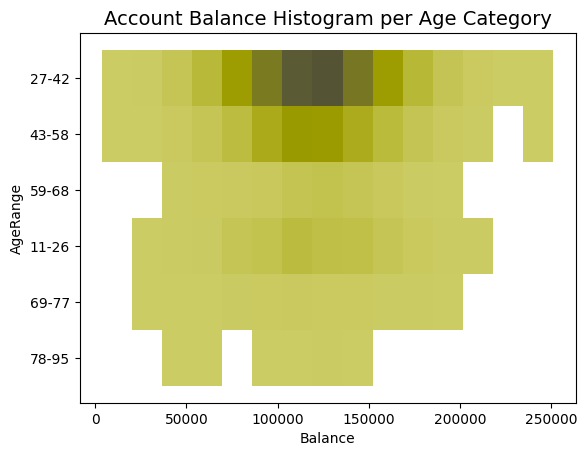

In [9]:
#filter the customers by account balance > 2500
over_balance = churn_data[churn_data['Balance'] > 2500]

#group by age category, and show the aggregate functions for count (number of accounts), mean (average value), median, and min / max on account balance
over_balance.groupby(by = 'AgeRange', as_index=False)['Balance'].agg(['count', 'mean', 'median', 'min', 'max']).round(0) \
    .sort_values(by='count', ascending=False) #round to full number, and sort by highest count first
    
#build a histogram by AgeRange and Account Balance
histogram = sns.histplot(
    data=over_balance,
    x='Balance',
    y='AgeRange',
    bins=15,
    color='yellow',
    )
histogram.set_title('Account Balance Histogram per Age Category', fontsize=14);

Comments: \
The histogram shows that the highest concentration of accounts with a balance over 2500 is between the age groups of:
- 27-42: Millenials
- 43-58: Gen X

The concentration of money tends to be between 110000 and 125000 for all age groups. Thus account balance on average tends to concentrate somewhere in the middle. \
Anomalies tend to be found in Millenials and Gen X, i.e. they have the highest range difference in account balance. Thus they tend to be more spread money wise, i.e. can have account holders with a small balance, and with a very high balance: over 200000 worth. \
Pensioners (70+) tend to keep less accounts in general.


На гистограмме видно, что наибольшая концентрация счетов с балансом более 2500 приходится на возрастные группы:
- 27-42: Миллениалы
- 43-58: Поколение Х

Концентрация денег обычно составляет от 110 000 до 125 000 для всех возрастных групп. Таким образом, баланс счета в среднем имеет тенденцию концентрироваться где-то посередине. \
Аномалии, как правило, встречаются у миллениалов и поколения х, т. е. у них самая высокая разница в балансе счета. \
Пенсионеры (70+), как правило, имеют меньше счетов.

Exercise 9.3: \
Посмотрите на распределение баланса клиента в разрезе признака оттока. \
Как различаются суммы на накопительном счёте ушедших и лояльных клиентов? \
Подумайте и напишите, с чем это может быть связано, что может не устраивать ушедших клиентов в банке.

In [10]:
#split the data by gender
bar_data = churn_data.groupby(
    by=['Gender', 'Status'],
    as_index=False
)[['Balance']].sum().round()

#build a bar chart
fig = px.bar(
    data_frame=bar_data,
    x='Status',
    y='Balance',
    color='Gender', #stack by gender
    text = 'Balance', 
    orientation='v',
    height=500,
    width=600,
    title='Client Account Balance by Loyalty Status'
)

fig.show()

Comments: \
The bar chart shows that exited women have a higher balance than exited men, and the opposite is true for loyal clients. \
The likely reason is that women tend to spend more, and need higher credit features / incentives that the banks do not yet offer.


Гистограмма показывает, что у ушедших женщин баланс выше, чем у ушедших мужчин, а для лояльных клиентов верно обратное. \
Вероятная причина заключается в том, что женщины, как правило, тратят больше и нуждаются в более высоких кредитных стимулах, которые банки пока не предлагают.

Exercise 9.4: \
Посмотрите на распределение возраста в разрезе признака оттока. \
В какой группе больше потенциальных выбросов? \
На какую возрастную категорию клиентов стоит обратить внимание банку?

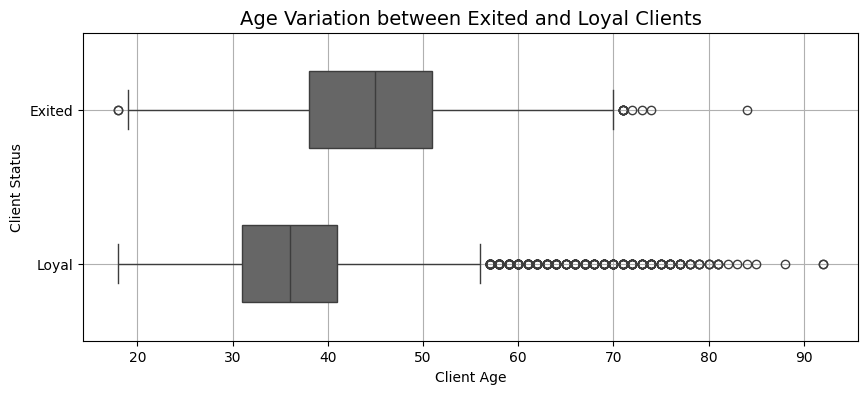

In [11]:
#set the canvas
fig = plt.figure(figsize=(10, 4))

#built a boxplot
boxplot = sns.boxplot(
    data=churn_data,
    y='Status',
    x='Age',
    orient='h',
    width=0.5,
    color='0.4'
);
boxplot.set_title('Age Variation between Exited and Loyal Clients', fontsize=14)
boxplot.set_xlabel('Client Age')
boxplot.set_ylabel('Client Status')
boxplot.grid()

Comments: \
The box plot is another good chart to compare categorical data. \
The chart shows that there are more exited clients in their late 30s to early 50s while most loyal clients tend to be in their early 30s to early 40s, thus the loyal programme should focus on retaining the clients in this age group. \
But the chart also shows that there are many anomalies in the loyal clients group past the age of 55. Thus more data analysis is needed to find the reason for these anomalies in the data. Possibly once clients reach their pension age and / or retire, they tend to keep up with the loyalty programme rather than look for alternatives.


Диаграмма показывает, что больше ушедших клиентов в возрасте от 30 до 50 лет, в то время как наиболее лояльные клиенты, как правило, находятся в возрасте от 30 до 40 лет, поэтому программа лояльности должна быть направлена на удержание клиентов в этой возрастной группе. \
Но диаграмма также показывает, что существует много аномалий в группе лояльных клиентов старше 55 лет. Таким образом, необходим дополнительный анализ данных, чтобы найти причину этих аномалий в данных. Возможно, когда клиенты достигают пенсионного возраста и/или выходят на пенсию, они склонны следовать программе лояльности, а не искать альтернативы.

Exercise 9.5: \
Постройте график, который показывает взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты. \
Добавьте расцветку по признаку оттока клиентов. \
Какова взаимосвязь между признаками? Если не видите явной взаимосвязи, укажите это.

In [20]:
#scatter plot is too chaotic, and doesn't show a link
#build an empirical cumulative distribution plot
cumul_distr = px.scatter(
        churn_data,
        x='CreditScore',
        y='EstimatedSalary',
        color='Status'
        )

cumul_distr.show()

Comments: \
The estimated salary of loyal clients is 4x times higher than those of exited clients. \
The lowest credit rating belongs to the exited clients: from 350-354 while the lowest credit score of loyal clients starts at 405 onwards.


Ориентировочная зарплата лояльных клиентов в 4 раза выше, чем у ушедших клиентов. \
Самый низкий кредитный рейтинг принадлежит ушедшим клиентам: от 350 до 354, а самый низкий кредитный рейтинг у лояльных клиентов начинается с 405 и выше.

Exercise 9.6: \
Кто чаще уходит, мужчины или женщины? \
Постройте график, который иллюстрирует это.

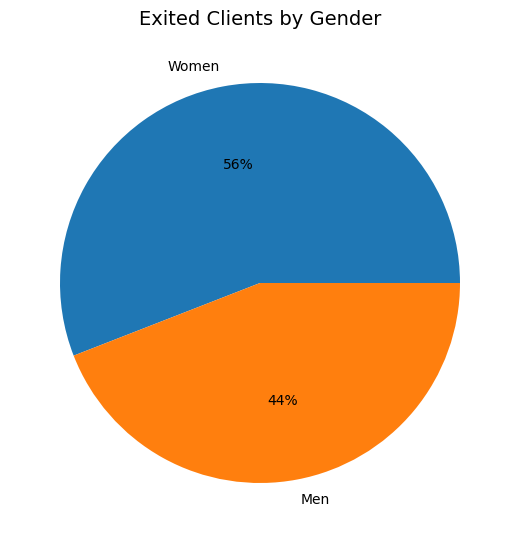

In [13]:
#create a filtered variable for exited clients, and find its proportion values
exited_clients = churn_data[churn_data['Status'] == 'Exited'].groupby('Gender')['Status'].value_counts()

#build a pie chart to show the ratio difference between men and women
fig = plt.figure(figsize=(5, 5))
pie_data = fig.add_axes([0, 0, 1, 1]) # full scale
pie_data.pie(
    exited_clients,
    labels=('Women', 'Men'),
    autopct='%.f%%', # to whole number
    explode = [0, 0]
);

title = pie_data.set_title('Exited Clients by Gender', fontsize=14)

Comments: \
Women leave more often, the difference in ratio is a little over than half (56%).

Женщины уходят чаще, разница в соотношении составляет чуть больше половины (56%).

Exercise 9.7: \
Как отток клиентов зависит от числа приобретённых у банка услуг? \
Для ответа на этот вопрос постройте многоуровневую столбчатую диаграмму.

In [14]:
#build a histogram
hist_data = px.histogram(
    churn_data,
    x = 'Status',
    color = 'NumOfProducts',
    width = 700,
    height = 500,
    title='Distribution between Number of Products and Client Status'
)
hist_data.update_layout(bargap=0.35)
hist_data.show()

Comments: \
Loyal clients have a higher number of products in number, but not in variety. \
Loyal clients dominate in purchasing 1-2 products, yet have a small number of 3 products, and 4 products are not used by any loyal client. \
However, exited clients have used more than 2 products, and there are clients with 3-4 products used.

Лояльные клиенты имеют большее количество продуктов по количеству, но не по разнообразию. \
Лояльные клиенты преобладают в покупке 1-2 товаров, но 3-х товаров у них мало, а 4-мя товарами не полузуется ни один лояльный клиент. \
Однако ушедшие клиенты использовали более 2 продуктов, а есть и клиенты, использовавшие 3-4 продукта.

Exercise 9.8: \
Как влияет наличие статуса активного клиента на отток клиентов? \
Постройте диаграмму, иллюстрирующую это. \
Что бы вы предложили банку, чтобы уменьшить отток клиентов среди неактивных?

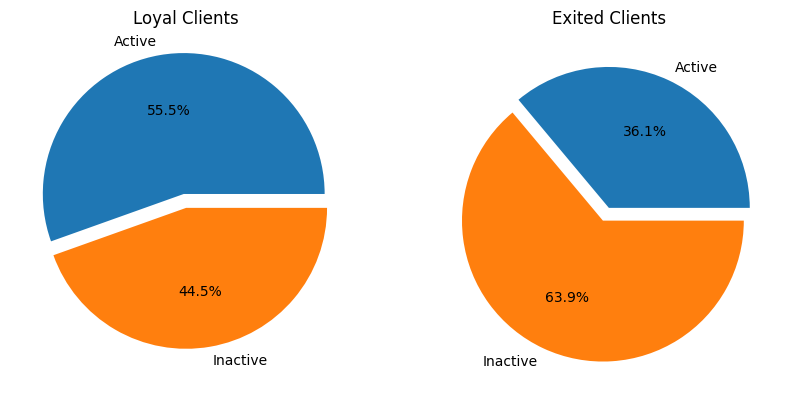

In [15]:
#filter the data by loyalty status and group by account status
status_loyal = churn_data[churn_data['Status'] == 'Loyal'].groupby(['AccountStatus'])['AccountStatus'].value_counts()
status_exited = churn_data[churn_data['Status'] == 'Exited'].groupby(['AccountStatus'])['AccountStatus'].value_counts()

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot each pie chart in a separate subplot
# build a pie chart for loyal clients
ax1.pie(
    status_loyal,
    labels=('Active', 'Inactive'),
    autopct='%.1f%%', # to 1dp
    explode = [0.1, 0]
);
ax1.set_title('Loyal Clients')

# build a pie chart for exited clients
ax2.pie(
    status_exited,
    labels=('Active', 'Inactive'),
    autopct='%.1f%%', # to 1dp
    explode = [0, 0.1],
);
ax2.set_title('Exited Clients')

# show both charts
plt.show()

Comments: \
Loyal clients have a higher active status of 55.5% compared to exited clients with 36.1%. \
Banks should work to increase the clients activity level by creating better products / services, improving engagement and communication with the client to see what kind of products / services they'd like to use.


Лояльные клиенты имеют более высокий активный статус (55,5%) по сравнению с ушедшими клиентами (36,1%). \
Банки должны работать над повышением уровня активности клиентов, создавая более качественные услуги, улучшая взаимодействие и общение с клиентами, чтобы увидеть, какие услуги они хотели бы использовать.

Exercise 9.9: \
В какой стране доля ушедших клиентов больше? \
Постройте тепловую картограмму, которая покажет это соотношение на карте мира. \
Предположите, с чем это может быть связано.

In [16]:
#group by country, and calculate the proportion of exited clients: exited / total number of clients
country_map = (churn_data.groupby(['Geography'])['Exited'].mean() * 100).round(2)

#build a choropleth
fig = px.choropleth(
    data_frame=country_map, 
    locations=country_map.index, 
    locationmode='country names',
    color='Exited',
    range_color=[0, 35],
    title='Proportion of Exited Clients by Country',
    scope='europe', #limit to one region
    width=600, 
    height=400,
    color_continuous_scale='fall', #палитра цветов
    center={'lat': 55, 'lon': 10}
)
fig.show()

Comments: \
The graph shows that proportionally to the total number of clients at the bank, the number of exited clients in countries: France and Spain are lower (<17%) compared to Germany (32.4%). \
The discrepancy can be with the current economical situation, possibly there are better incentive programmes in France and Spain compared to Germany.

На графике видно, что пропорционально общему количеству клиентов банка количество ушедших клиентов в странах: Франции и Испании ниже (<17%) по сравнению с Германией (32,4%). \
Несоответствие может быть с текущей экономической ситуацией, возможно, во Франции и Испании существуют лучшие программы стимулирования по сравнению с Германией.

Exercise 9.10: \
Переведите числовой признак CreditScore в категориальный. \
Для этого воспользуйтесь функцией get_credit_score_cat(), которая приведена ниже. \
Примените её к столбцу CreditScore и создайте новый признак CreditScoreCat — категории кредитного рейтинга.

In [17]:
#import the function
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"

#apply the function for CreditScore
churn_data['CreditScoreCat'] = churn_data['CreditScore'].apply(get_credit_score_cat)

Постройте сводную таблицу, строками которой являются категории кредитного рейтинга (CreditScoreCat), а столбцами — количество лет, в течение которых клиент пользуется услугами банка (Tenure). \
В ячейках сводной таблицы должно находиться среднее по признаку оттока (Exited) — доля ушедших пользователей. \
На основе полученной сводной таблицы постройте тепловую карту с аннотацией. \
Найдите на тепловой карте категории клиентов, которые уходят чаще всего.

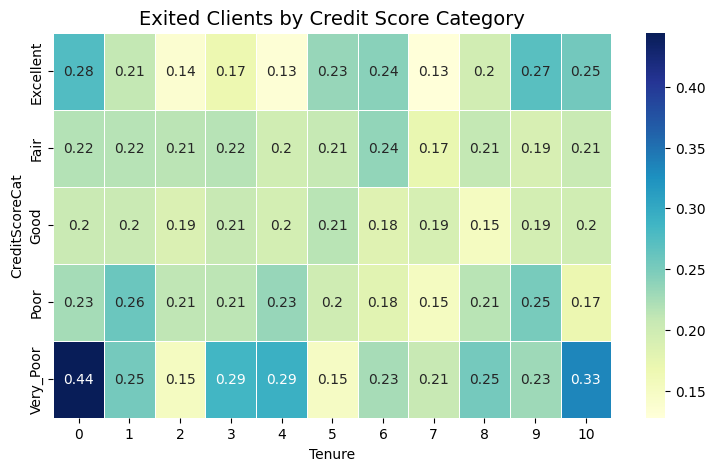

In [18]:
#create a pivot table with credit category by tenure
credit_cat_by_tenure = churn_data.pivot_table(
    values = 'Exited',
    index = 'CreditScoreCat',
    columns='Tenure',
    aggfunc='mean'
)

#set the canvas
plt.figure(figsize = (9, 5))

heatmap_exited = sns.heatmap(
    data=credit_cat_by_tenure,
    cmap='YlGnBu',
    annot=True,
    linewidth=.5
)
heatmap_exited.set_title('Exited Clients by Credit Score Category', fontsize=14);

Comments: \
The biggest discrepancy is found in the very_poor and excellent categories. \
Clients with the worst credit history (very_poor) tend to leave in either less than a year of tenure or after 10 years of tenure, show the highest range proportion wise. \
Similar case is found with clients with excellent history: tend to leave in the first year, or tenure years: 9-10. \
Clients with good and fair credit history doesn't show a pattern one way or the other, tend to behave similarly across year on year.


Наибольшее расхождение наблюдается в категориях very_poor и excellent. \
Клиенты с худшей кредитной историей (very_poor), как правило, уходят либо менее чем через год, либо через 10 лет, что демонстрирует самый высокий диапазон пропорций. \
Аналогичный случай наблюдается с клиентами с exllent историей: они склонны уходить в первый год или со стажем: 9-10 лет. \
Клиенты с good и fair кредитной историей не демонстрируют той или иной закономерности и, как правило, ведут себя одинаково из года в год.